In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

torch.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"device: {device}")

device: cuda


In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))  # flatten 32x32x3 to 3072
])

trainset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

batch_size = 128
trainloader = DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

100%|██████████| 170M/170M [00:02<00:00, 80.1MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [3]:
class VAE(nn.Module):
    def __init__(self, input_dim=3072, hidden_dim=400, latent_dim=20):
        super(VAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU()
        )

        self.fc_mu = nn.Linear(hidden_dim, latent_dim) # mean
        self.fc_var = nn.Linear(hidden_dim, latent_dim) # std

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_var(h)

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return self.decoder(z), mu, log_var

In [4]:
model = VAE().to(device)
test_batch, _ = next(iter(trainloader))
test_batch = test_batch.to(device)
recon_batch, mu, log_var = model(test_batch)

print(f"input shape: {test_batch.shape}")
print(f"reconstructed shape: {recon_batch.shape}")
print(f"mu shape: {mu.shape}")
print(f"log_var shape: {log_var.shape}")

input shape: torch.Size([128, 3072])
reconstructed shape: torch.Size([128, 3072])
mu shape: torch.Size([128, 20])
log_var shape: torch.Size([128, 20])


In [5]:
def loss_function(recon_x, x, mu, log_var):
    # reconstruction loss (BCE)
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')

    # kl divergence loss = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

    return BCE + KLD

In [9]:
def train(model, trainloader, epochs=30):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch_idx, (data, _) in enumerate(tqdm(trainloader)):
            data = data.to(device)
            optimizer.zero_grad()

            recon_batch, mu, log_var = model(data)

            loss = loss_function(recon_batch, data, mu, log_var)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(trainloader.dataset)
        print(f"epoch [{epoch+1}/{epochs}] avg Loss: {avg_loss:.4f}")

In [10]:
def plot_reconstruction(model, data):
    model.eval()
    with torch.no_grad():

        recon_batch, _, _ = model(data.to(device))

        # plot original and reconstruction
        plt.figure(figsize=(12, 6))

        for i in range(8):
            plt.subplot(2, 8, i + 1)
            plt.imshow(data[i].view(3, 32, 32).permute(1, 2, 0).cpu())
            plt.axis('off')
            if i == 0:
                plt.title("original")

        for i in range(8):
            plt.subplot(2, 8, i + 9)
            plt.imshow(recon_batch[i].view(3, 32, 32).permute(1, 2, 0).cpu())
            plt.axis('off')
            if i == 0:
                plt.title("reconstruction")

        plt.tight_layout()

  0%|          | 0/391 [00:00<?, ?it/s]

epoch [1/30] avg Loss: 2025.6216


  0%|          | 0/391 [00:00<?, ?it/s]

epoch [2/30] avg Loss: 1939.7899


  0%|          | 0/391 [00:00<?, ?it/s]

epoch [3/30] avg Loss: 1906.8437


  0%|          | 0/391 [00:00<?, ?it/s]

epoch [4/30] avg Loss: 1887.1047


  0%|          | 0/391 [00:00<?, ?it/s]

epoch [5/30] avg Loss: 1874.7310


  0%|          | 0/391 [00:00<?, ?it/s]

epoch [6/30] avg Loss: 1867.2142


  0%|          | 0/391 [00:00<?, ?it/s]

epoch [7/30] avg Loss: 1862.6001


  0%|          | 0/391 [00:00<?, ?it/s]

epoch [8/30] avg Loss: 1859.0809


  0%|          | 0/391 [00:00<?, ?it/s]

epoch [9/30] avg Loss: 1856.3256


  0%|          | 0/391 [00:00<?, ?it/s]

epoch [10/30] avg Loss: 1854.0817


  0%|          | 0/391 [00:00<?, ?it/s]

epoch [11/30] avg Loss: 1852.2551


  0%|          | 0/391 [00:00<?, ?it/s]

epoch [12/30] avg Loss: 1850.7042


  0%|          | 0/391 [00:00<?, ?it/s]

epoch [13/30] avg Loss: 1849.5467


  0%|          | 0/391 [00:00<?, ?it/s]

epoch [14/30] avg Loss: 1848.5912


  0%|          | 0/391 [00:00<?, ?it/s]

epoch [15/30] avg Loss: 1848.0526


  0%|          | 0/391 [00:00<?, ?it/s]

epoch [16/30] avg Loss: 1847.2053


  0%|          | 0/391 [00:00<?, ?it/s]

epoch [17/30] avg Loss: 1846.8256


  0%|          | 0/391 [00:00<?, ?it/s]

epoch [18/30] avg Loss: 1846.2235


  0%|          | 0/391 [00:00<?, ?it/s]

epoch [19/30] avg Loss: 1845.7262


  0%|          | 0/391 [00:00<?, ?it/s]

epoch [20/30] avg Loss: 1845.2838


  0%|          | 0/391 [00:00<?, ?it/s]

epoch [21/30] avg Loss: 1845.1132


  0%|          | 0/391 [00:00<?, ?it/s]

epoch [22/30] avg Loss: 1844.6506


  0%|          | 0/391 [00:00<?, ?it/s]

epoch [23/30] avg Loss: 1844.4685


  0%|          | 0/391 [00:00<?, ?it/s]

epoch [24/30] avg Loss: 1844.1297


  0%|          | 0/391 [00:00<?, ?it/s]

epoch [25/30] avg Loss: 1843.7635


  0%|          | 0/391 [00:00<?, ?it/s]

epoch [26/30] avg Loss: 1843.4897


  0%|          | 0/391 [00:00<?, ?it/s]

epoch [27/30] avg Loss: 1843.4236


  0%|          | 0/391 [00:00<?, ?it/s]

epoch [28/30] avg Loss: 1843.2217


  0%|          | 0/391 [00:00<?, ?it/s]

epoch [29/30] avg Loss: 1842.7228


  0%|          | 0/391 [00:00<?, ?it/s]

epoch [30/30] avg Loss: 1842.8037


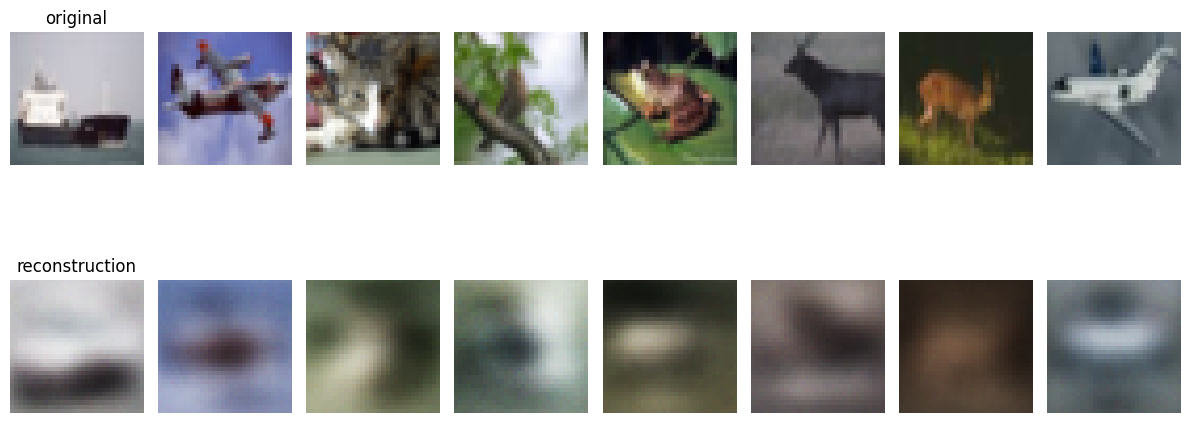

In [12]:
model = VAE().to(device)
train(model, trainloader, epochs=30)

test_batch, _ = next(iter(trainloader))
plot_reconstruction(model, test_batch)

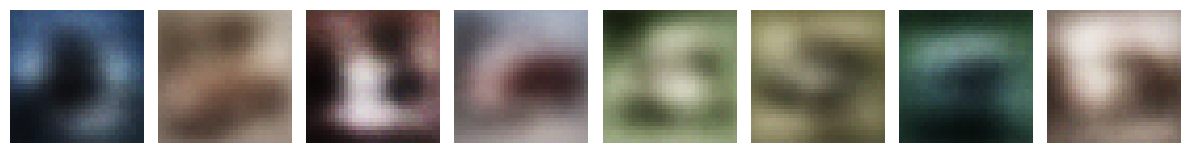

In [13]:
def generate_images(model, num_images=8):
    model.eval()
    with torch.no_grad():

        z = torch.randn(num_images, 20).to(device)
        sample = model.decoder(z)

        plt.figure(figsize=(12, 3))
        for i in range(num_images):
            plt.subplot(1, num_images, i + 1)
            plt.imshow(sample[i].view(3, 32, 32).permute(1, 2, 0).cpu())
            plt.axis('off')
        plt.tight_layout()

generate_images(model)